<a href="https://colab.research.google.com/github/Aftermin/AM/blob/main/Simplified_DiffusionLight.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# DiffusionLight:  Light Probes for Free by Painting a Chrome Ball

[![Full paper](https://img.shields.io/badge/Full_paper-arXiv-b31b1b.svg)](https://arxiv.org/abs/2312.09168) [![GitHub stars](https://img.shields.io/github/stars/DiffusionLight/DiffusionLight.svg?style=social&label=Star&maxAge=2592000)](https://github.com/DiffusionLight/DiffusionLight)

This Colab demonstrates light estimation for the paper DiffusionLight.

You can estimate lighting on your own images or use our avaliable preset images.

This Colab is intended for a quick demonstration. If you want optimal results, please refer to the [Github repository.](https://github.com/DiffusionLight/DiffusionLight).

### Approximate time (Colab T4 GPU)

| Task | Time estimated |
| ---- | ----------------|
| Setup environment | 5 Minutes |
| Inpaint (default setting) | 2 Minutes |
| Inpaint (use_interative_inpainting) | 2 Hours |

In [ ]:
#@markdown <h3> ⚙️ Configuration</h3>
#@markdown <small>The input images will be resized to <b>image_width</b> for fast training.</small>


#@markdown <small>Exposure value to compute the chrome ball. (Value in 0 to -5, seperate by comma)</small>
ev_values =  "0, -5" # @param {type:"string"}
#@markdown <small><b>Iterative inpainting</b> Enabling this feature will improve the accuracy of light direction. However, it will take up to 2 hours to run on Google Colab</small>
use_iterative_inpaitning = False # @param {type:"boolean"}
ball_per_iteration = 30  # @param {type:"integer"}
num_iteration = 2   # @param {type:"integer"}

# safety check
# check for the EV
ev_values = ev_values.replace(" ", "")
ev_news = []
for ev in ev_values.split(","):
  ev = float(ev.strip())
  if ev > 0 or ev < -5:
    raise Exception("Our LoRA is currently design for EV in range [0, -5]")
  ev_news.append(f"{ev:.1f}")
ev_values = ",".join(ev_news)

Saving goose.png to goose.png


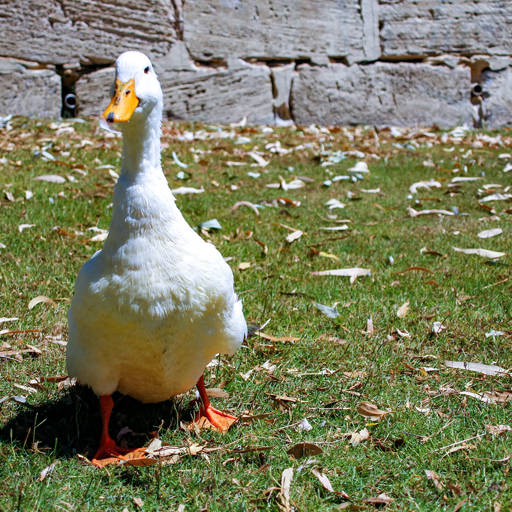

In [ ]:
#@markdown <h3> 🖼️ Input Image</h3>
#@markdown <small>Pick the preset image or upload your own image</small>
import os
from google.colab import files
from IPython.display import HTML
from PIL import Image

def pil_square_image(image, desired_size = (512,512), interpolation=Image.LANCZOS):
    """
    Make top-bottom border
    """
    # Don't resize if already desired size (Avoid aliasing problem)
    if image.size == desired_size:
        return image

    # Calculate the scale factor
    scale_factor = min(desired_size[0] / image.width, desired_size[1] / image.height)

    # Resize the image
    resized_image = image.resize((int(image.width * scale_factor), int(image.height * scale_factor)), interpolation)

    # Create a new blank image with the desired size and black border
    new_image = Image.new("RGB", desired_size, color=(0, 0, 0))

    # Paste the resized image onto the new image, centered
    new_image.paste(resized_image, ((desired_size[0] - resized_image.width) // 2, (desired_size[1] - resized_image.height) // 2))

    return new_image

scene = '\uD83D\uDCE4 upload your image' #@param ['🛏️ bed', '🌊 coast', '🧑 face', '🫖 kitchen',  '🌸 sakura', '🧱 wall', '📤 upload your image']
scene = ' '.join(scene.split(' ')[1:])


if scene == 'upload your image':
  display(HTML('<h3>Select your images</h3>'))
  uploaded = files.upload()
  preupload_datasets = [os.path.join(os.getcwd(), f) for f in uploaded.keys()]
  if len(preupload_datasets) > 1:
    for f in preupload_datasets[1:]:
      os.remove(f)
    display(HTML('<h3 style="color:red">Found more than 1 input, we will take only first input to process</h3>'))
  input_image = preupload_datasets[0]
else:
  scene_url = "https://diffusionlight.github.io/image-other/input/"+scene+".png"
  if not os.path.exists(scene+".png"):
    !wget {scene_url}  &> /dev/null
  input_image = os.path.join(os.getcwd(), scene+".png")

image = Image.open(input_image)
image = pil_square_image(image, (1024,1024))

# create _preview_image
display(HTML("<h2>Selected input image: </h2>"))
preview_image = image.copy()
display(preview_image.resize((512,512)))

In [ ]:
#@markdown <h3> 📥 Setup environment</h3>
if 'already_setup_env' not in globals():
  !git clone https://github.com/DiffusionLight/DiffusionLight.git
  %cd DiffusionLight

  # install non-standard colab library
  !pip install skylibs==0.7.4
  !pip install accelerate==0.21.0
  !pip install datasets==2.13.1
  !pip install sentence-transformers==2.7.0
  !pip install transformers==4.36.0
  !pip install diffusers==0.21.0
  ! pip install huggingface-hub==0.19.4
  # use custom openexr
  !pip install git+https://github.com/jamesbowman/openexrpython.git


  # predownload SDXL model
  import torch
  from transformers import pipeline
  from diffusers import AutoencoderKL, StableDiffusionXLControlNetInpaintPipeline, ControlNetModel
  vae = AutoencoderKL.from_pretrained("madebyollin/sdxl-vae-fp16-fix", torch_dtype=torch.float16)
  controlnet = ControlNetModel.from_pretrained(
      "diffusers/controlnet-depth-sdxl-1.0",
      torch_dtype=torch.float16,
      variant="fp16",
  )
  pipe = StableDiffusionXLControlNetInpaintPipeline.from_pretrained(
      "stabilityai/stable-diffusion-xl-base-1.0",
      controlnet=controlnet,
      torch_dtype=torch.float16,
      variant="fp16"
  )
  depth_estimator = pipeline(task="depth-estimation", model="Intel/dpt-hybrid-midas")
  # free up memory after preload sdxl
  del vae
  del controlnet
  del pipe
  del depth_estimator


  # mark that environment is already setup, So it is not reinitial when second run
  already_setup_env = 1

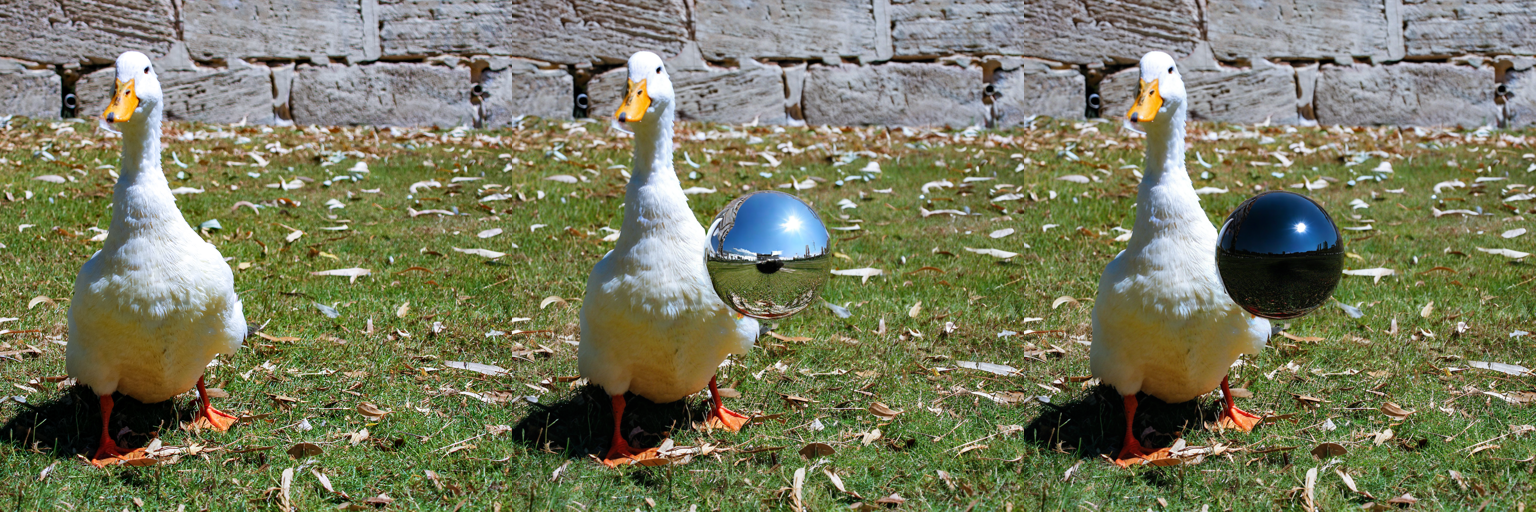

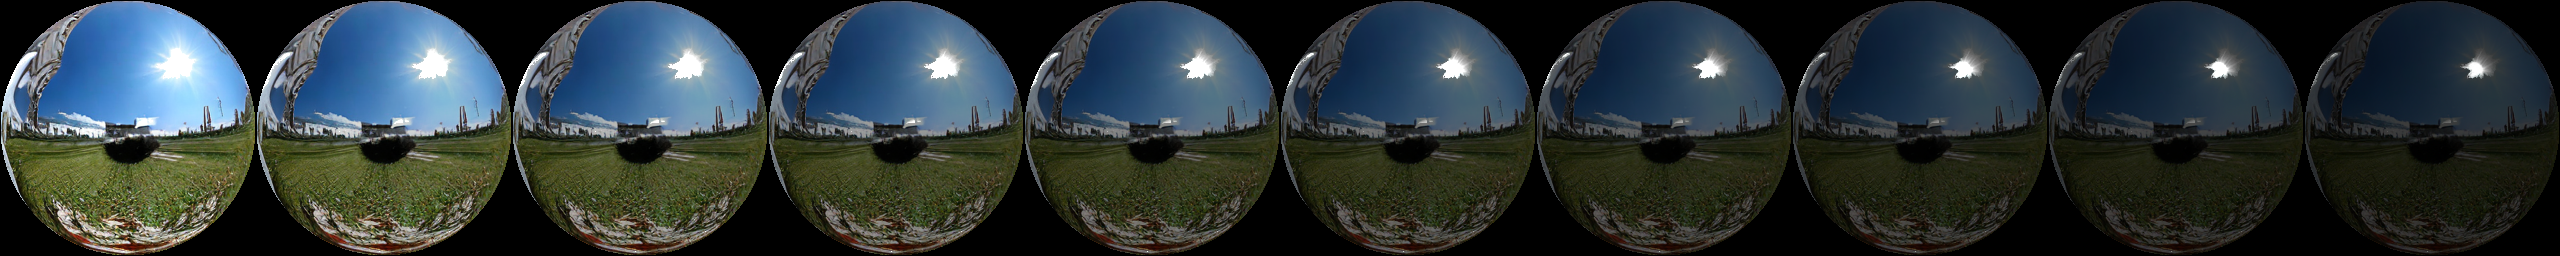

In [ ]:
#@markdown <h3>🖌️ Inpainting Chromeball</h3>

# clear old result
!rm -rf input
!rm -rf output

# prepare new input
os.makedirs("input",exist_ok=True)
image.save("input/image.png")

# actual processing
algorithm = "iterative" if use_iterative_inpaitning else "normal"
!python inpaint.py --dataset input --output_dir output --no_torch_compile --algorithm {algorithm} --ev {ev_values} --ball_per_iteration {ball_per_iteration} --num_iteration {num_iteration}

# create an environment map
!python ball2envmap.py --ball_dir output/square --envmap_dir output/envmap &> /dev/null
!python exposure2hdr.py --input_dir output/envmap --output_dir output/hdr --EV {ev_values} --preview &> /dev/null

# create chromeball preview
import torch
import numpy as np
import skimage
import os
def get_circle_mask(size=256):
    x = torch.linspace(-1, 1, size)
    y = torch.linspace(1, -1, size)
    y, x = torch.meshgrid(y, x)
    z = (1 - x**2 - y**2)
    mask = z >= 0
    return mask

def cropped_ball(input_dir, output_dir):
    mask = get_circle_mask().numpy()
    files = os.listdir(input_dir)
    os.makedirs(output_dir, exist_ok=True)
    for filename in files:
      try:
        image = skimage.io.imread(os.path.join(input_dir, filename))
      except:
        continue
      image[mask == 0] = 0
      image = np.concatenate([image,  (mask*255)[...,None]], axis=2)
      image = image.astype(np.uint8)
      skimage.io.imsave(os.path.join(output_dir, filename), image)
cropped_ball("output/square", "output/ball")
!python exposure2hdr.py --input_dir output/ball --output_dir output/hdr_ball --EV "0,-5" --preview  &> /dev/null

from IPython.display import clear_output
clear_output(wait=True)

# show image
import numpy as np
pred_images = [np.asarray(Image.open("input/image.png").resize((512,512)))]
for ev_value in ev_values.split(","):
  ev_str = ev_value.replace(".", "")
  if not ev_str.startswith("-"):
    ev_str = "-"+ev_str
  pred_images.append(np.asarray(Image.open("output/raw/image_ev"+ev_str+".png").resize((512,512))))
pred_images = np.concatenate(pred_images,axis=1)
pred_images = Image.fromarray(pred_images)
display(HTML("<h3>Inpainted Image</3> "))
display(pred_images)

# show HDR chromeball
hdr_ball = Image.open("output/hdr_ball/preview/image.png")
display(HTML("<h3>Chromeball in different exposure</3> "))
display(hdr_ball)

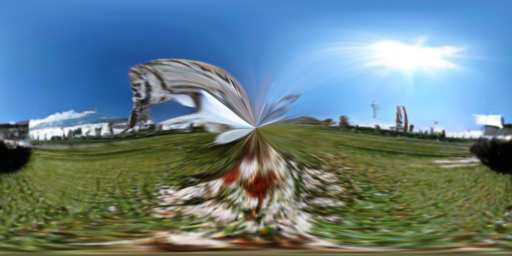

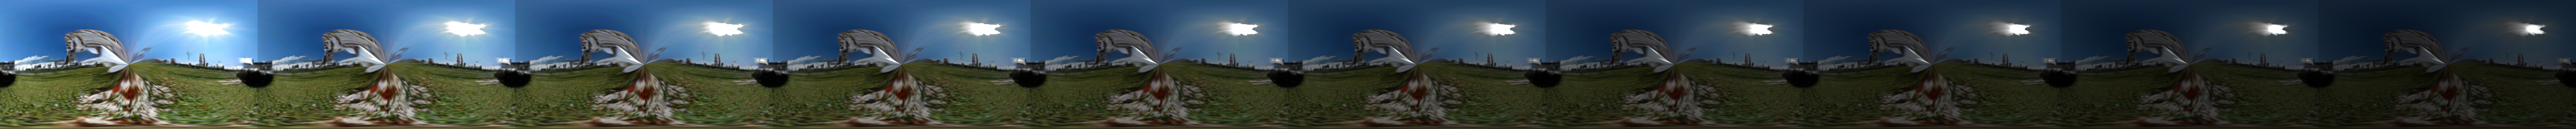

In [ ]:
#@markdown <h3>🗺️ Project to Environment map</h3>
if os.path.exists("output/envmap/image_ev-00.png") and os.path.exists("output/hdr/preview/image.png"):
  # show environment map
  hdr_ball = Image.open("output/envmap/image_ev-00.png")
  display(HTML("<h3>Predicted Environment map</3> "))
  display(hdr_ball)

  # show HDR enivornment map
  hdr_ball = Image.open("output/hdr/preview/image.png")
  display(HTML("<h3>Environment map in differnt exposure</3> "))
  display(hdr_ball)
else:
    display(HTML('<h3 style="color:red">Error: Cannot find Environment map! Please make sure inpaint step is run without any error</h3>'))

In [ ]:
#@markdown <h3>👇 Download Environment map in EXR format</h3>
if os.path.exists("output/hdr/image.exr") and os.path.exists("output/hdr/preview/image.png"):
  from google.colab import files
  from ipywidgets import Button


  def on_button_clicked(b):
    files.download('output/hdr/image.exr')


  button = Button(description="Download EXR Environment map")
  button.on_click(on_button_clicked)
  display(HTML("<h4>Please click the button below to download EXR Environment map</h4><br>"))
  display(button)

else:
    display(HTML('<h3 style="color:red">Error: Cannot find Environment map! Please make sure inpaint step is run without any error</h3>'))

Button(description='Download EXR Environment map', style=ButtonStyle())

## Visit us 🦉
[![Vision & Learning Laboratory](https://i.imgur.com/hQhkKhG.png)](https://vistec.ist/vision) [![VISTEC - Vidyasirimedhi Institute of Science and Technology](https://i.imgur.com/4wh8HQd.png)](https://vistec.ac.th/)
